In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

## 1. How many different cases are there, by department?

In [2]:
(
    df.groupBy("department", 'service_request_type')
    .count()
    .toPandas()
    .groupby('department')
    .service_request_type
    .count()
    .sort_values()
)
    

department
City Council                  2
Customer Service              2
Animal Care Services         14
Metro Health                 14
Parks & Recreation           44
Solid Waste                  56
Trans & Cap Improvements     81
DSD/Code Enforcement        122
Name: service_request_type, dtype: int64

<AxesSubplot:ylabel='department'>

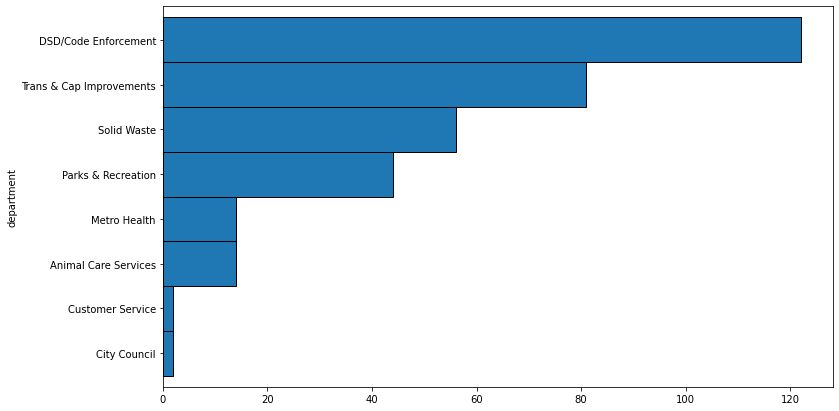

In [3]:
(
    df.groupBy("department", 'service_request_type')
    .count()
    .toPandas()
    .groupby('department')
    .service_request_type
    .count()
    .sort_values()
    .plot.barh(width=1, ec="black", figsize=(12,7))
)
    

## 2. Does the percentage of cases that are late vary by department?



In [4]:
(
    df.select('department', 'case_late')
    .toPandas()
    .groupby('department')
    .case_late
    .mean()
    .sort_values()
)

department
City Council                0.000000
Trans & Cap Improvements    0.056251
DSD/Code Enforcement        0.081634
Solid Waste                 0.117968
Metro Health                0.160566
Parks & Recreation          0.190737
Animal Care Services        0.199085
Customer Service            0.705511
Name: case_late, dtype: float64

In [5]:
df.case_late

Column<b'case_late'>

In [6]:
#pd.crosstab(df.department, df.case_late, normalize=True)

Text(0.5, 0, 'Percentage')

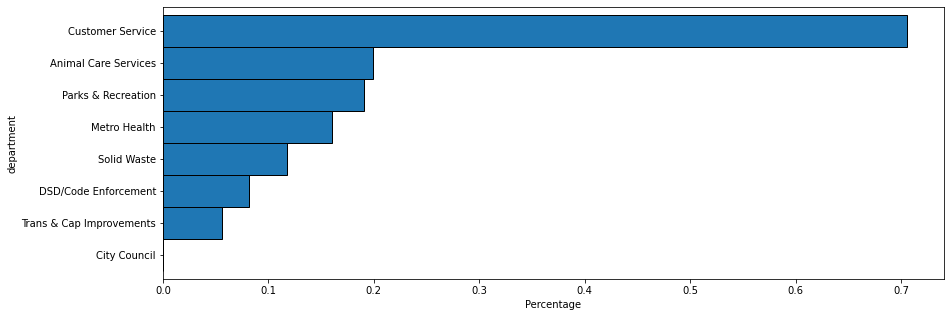

In [7]:
(
    df.select('department', 'case_late')
    .toPandas()
    .groupby('department')
    .case_late
    .mean()
    .sort_values()
    .plot.barh(width=1, ec='black', figsize=(14,5))
)
plt.xlabel('Percentage')

## 3. On average, how late are the late cases by department?

In [8]:
(
    df.filter(df.case_late == 'true')
    .groupby('department')
    .agg(round(mean('num_days_late'), 0).alias('avg_days_late'))
    .toPandas()
    .sort_values('avg_days_late', ascending =False)
)

,department,avg_days_late
4,Customer Service,88.0
6,DSD/Code Enforcement,49.0
1,Animal Care Services,23.0
3,Parks & Recreation,22.0
2,Trans & Cap Improvements,11.0
0,Solid Waste,7.0
5,Metro Health,7.0


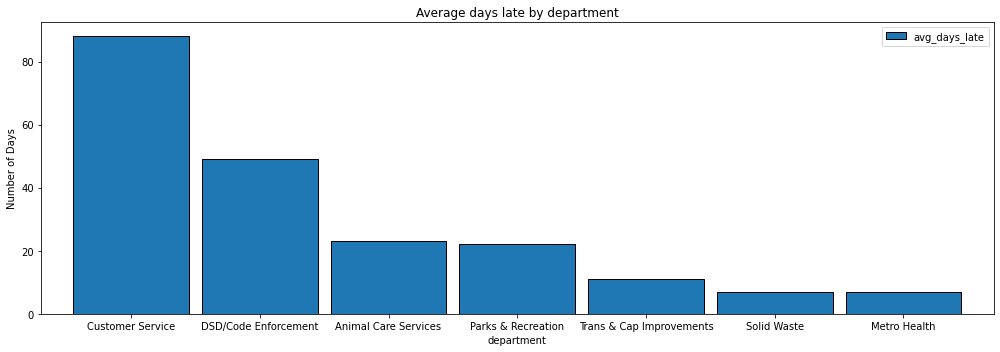

In [9]:
(
    df.filter(df.case_late == 'true')
    .groupby('department')
    .agg(round(mean('num_days_late'), 0).alias('avg_days_late'))
    .toPandas()
    .set_index('department')
    .sort_values(by='avg_days_late', ascending =False)
    .plot.bar(width=.9, ec="black", figsize=(14, 5))
)
plt.xticks(rotation=0)
plt.title("Average days late by department")
plt.ylabel("Number of Days")
plt.tight_layout()

## 4. What is the service type that is the most late? Just for Parks & Rec?



In [10]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



In [11]:
(
    df.filter(df.case_late == 'true')
    .filter(df.department == "Parks & Recreation")
    .groupBy('service_request_type')
    .agg(mean('num_days_late').alias('avg_days_late'))
    .toPandas()
    .set_index('service_request_type')
    .sort_values(by='avg_days_late', ascending =False)
    .head(5)
)

,avg_days_late
service_request_type,
Amenity Park Improvement,76.870182
Major Park Improvement Install,75.794504
Reservation Assistance,66.031163
Park Building Maint Invest,59.367470
Sportfield Lighting,51.480050


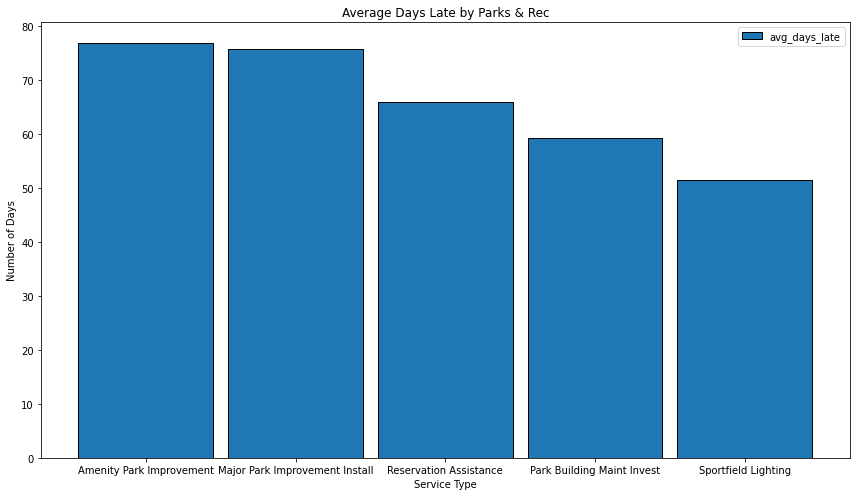

In [12]:
(
    df.filter(df.case_late == 'true')
    .filter(df.department == "Parks & Recreation")
    .groupBy('service_request_type')
    .agg(mean('num_days_late').alias('avg_days_late'))
    .toPandas()
    .set_index('service_request_type')
    .sort_values(by='avg_days_late', ascending =False)
    .head(5)
    .plot.bar(width=.9, ec='black', figsize=(12,7))
)
plt.xticks(rotation=0)
plt.title("Average Days Late by Parks & Rec")
plt.xlabel("Service Type")
plt.ylabel("Number of Days")
plt.tight_layout()

## 5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [13]:
dept_list = (
    df.select(df.department)
    .toPandas()
    .department
    .unique()
)
dept_list.shape[0]

8

In [14]:
(
     df.filter(df.department == dept_list[0])
    .groupby('service_request_type')
    .count()
    .sort(col("count").desc())
    .toPandas()
    .head(5)
)

,service_request_type,count
0,Stray Animal,26760
1,Aggressive Animal(Non-Critical),24882
2,Animal Neglect,13441
3,Trapped/Confined Animal,11354
4,Public Nuisance(Own Animal),10715


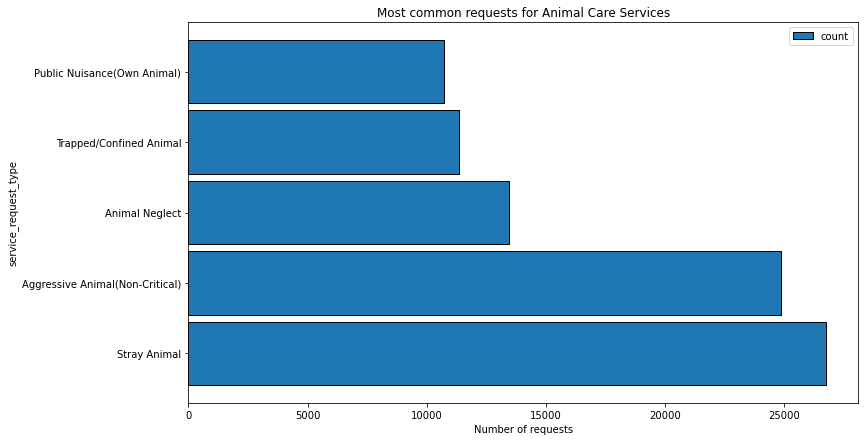

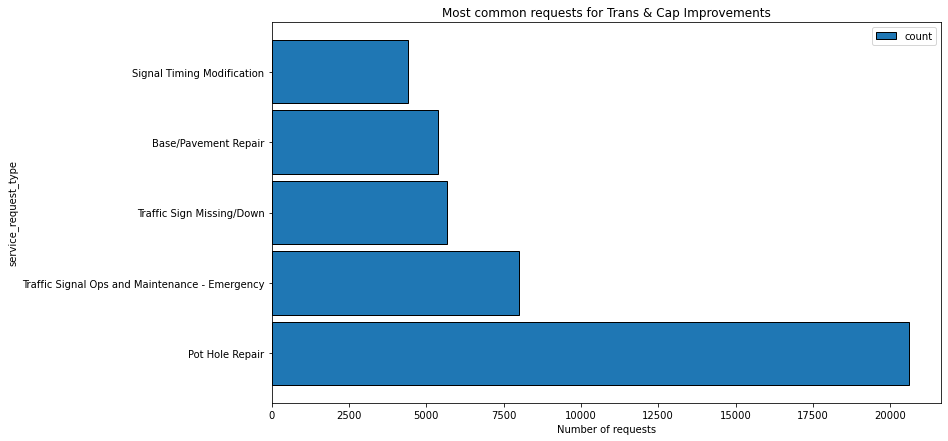

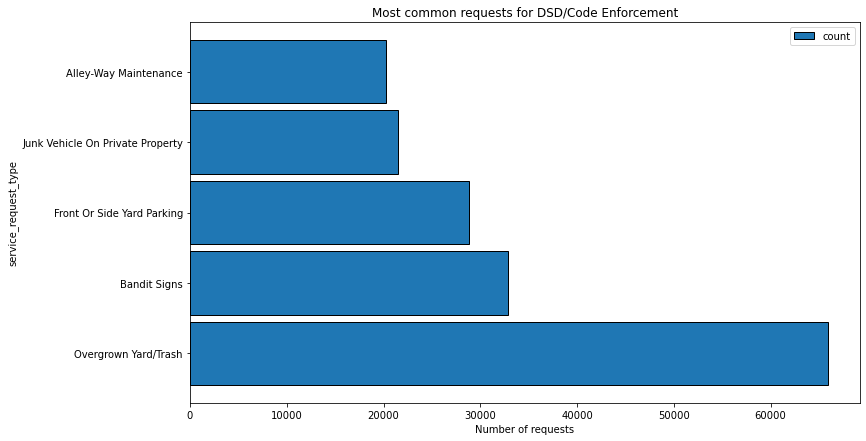

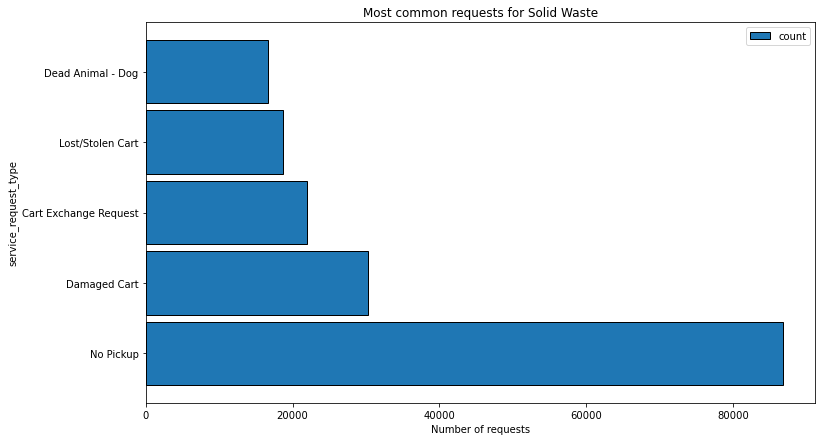

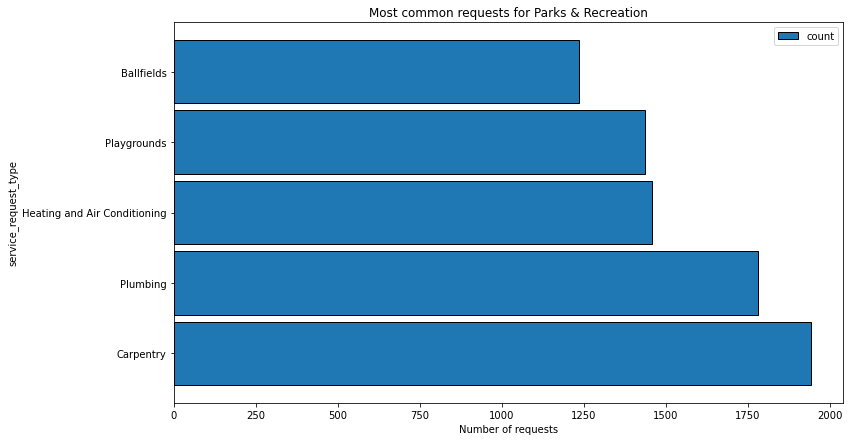

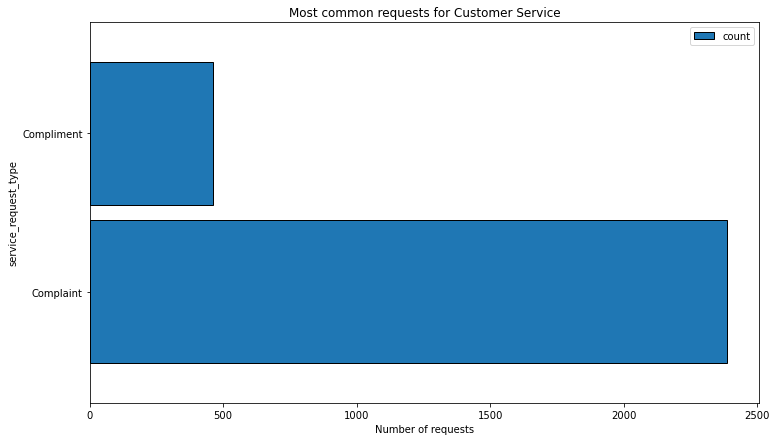

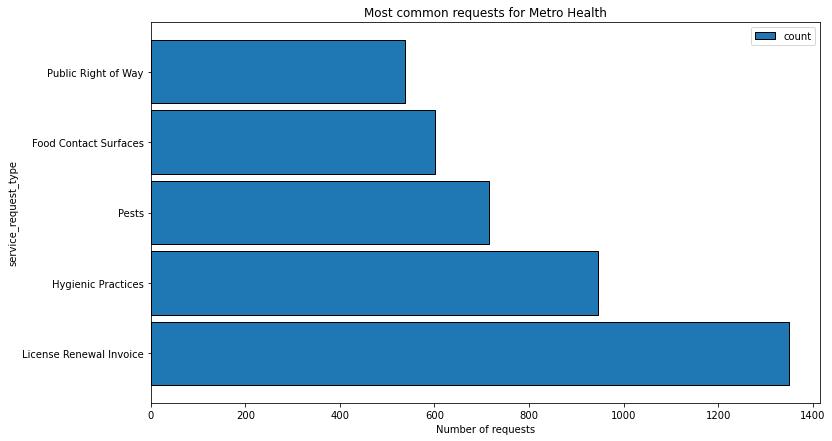

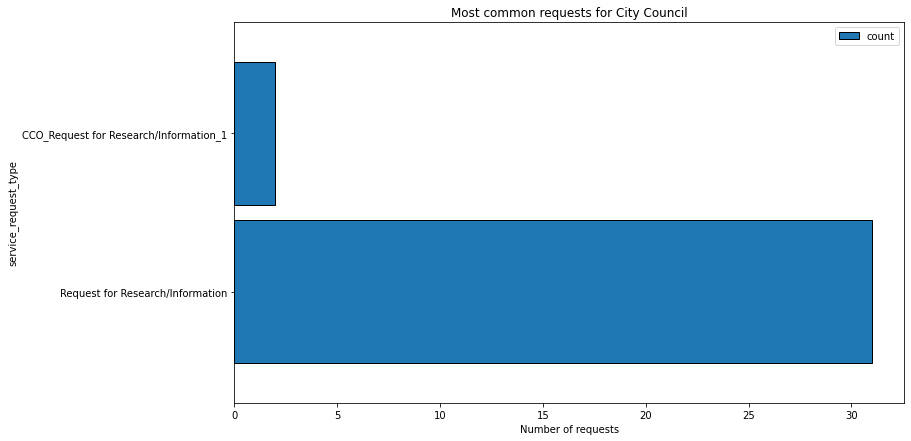

In [15]:
for i in range(dept_list.shape[0]):
    (
        df.filter(df.department == dept_list[i])
        .groupby('service_request_type')
        .count()
        .sort(col("count").desc())
        .toPandas()
        .head(5)
        .set_index("service_request_type")
        .plot.barh(width=.9, ec="black", figsize=(12, 7))
    )

    plt.title(f"Most common requests for {dept_list[i]}")
    plt.xlabel("Number of requests")

## 6. Does whether or not its a weekend matter for when a case is opened/closed?



In [16]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



In [17]:
cases_by_day = df.select(
    'department',
    date_format('case_opened_date', 'yyyy-MM-dd').alias('case_opened_date'),
    date_format('case_closed_date', 'yyyy-MM-dd').alias('case_closed_date')
)
cases_by_day.show(3)

+--------------------+----------------+----------------+
|          department|case_opened_date|case_closed_date|
+--------------------+----------------+----------------+
|Animal Care Services|      2018-01-01|      2018-01-01|
|Trans & Cap Impro...|      2018-01-01|      2018-01-03|
|Trans & Cap Impro...|      2018-01-01|      2018-01-02|
+--------------------+----------------+----------------+
only showing top 3 rows



In [18]:
x=lambda a : a+10
print(x(5))

15


In [19]:
x = lambda a, b : a * b
print(x(5, 6))

30


In [20]:
cases_opened_by_day = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_by_day.name='cases_open'
cases_opened_by_day

case_opened_date
2017-01-01     155
2017-01-02    1397
2017-01-03    1760
2017-01-04    1613
2017-01-05    1791
              ... 
2018-08-04     665
2018-08-05     319
2018-08-06    2071
2018-08-07    2405
2018-08-08     604
Name: cases_open, Length: 585, dtype: int64

In [21]:
cases_closed_by_day = (
    cases_by_day
    .groupby('case_closed_date')
    .count()
    .na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')
    ['count']# Shows the column name
)
cases_closed_by_day.name = 'cases_closed'
cases_closed_by_day

case_closed_date
2017-01-01      67
2017-01-02     385
2017-01-03     734
2017-01-04    1206
2017-01-05    1173
              ... 
2018-08-04     730
2018-08-05     197
2018-08-06    1713
2018-08-07    2096
2018-08-08     680
Name: cases_closed, Length: 585, dtype: int64

In [22]:
open_closed = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)

In [23]:
open_closed

,cases_open,cases_closed
2017-01-01,155,67
2017-01-02,1397,385
2017-01-03,1760,734
2017-01-04,1613,1206
2017-01-05,1791,1173
...,...,...
2018-08-04,665,730
2018-08-05,319,197
2018-08-06,2071,1713
2018-08-07,2405,2096


In [24]:
open_closed['day_of_week'] = open_closed.index.day_name()

In [25]:
open_closed

,cases_open,cases_closed,day_of_week
2017-01-01,155,67,Sunday
2017-01-02,1397,385,Monday
2017-01-03,1760,734,Tuesday
2017-01-04,1613,1206,Wednesday
2017-01-05,1791,1173,Thursday
...,...,...,...
2018-08-04,665,730,Saturday
2018-08-05,319,197,Sunday
2018-08-06,2071,1713,Monday
2018-08-07,2405,2096,Tuesday


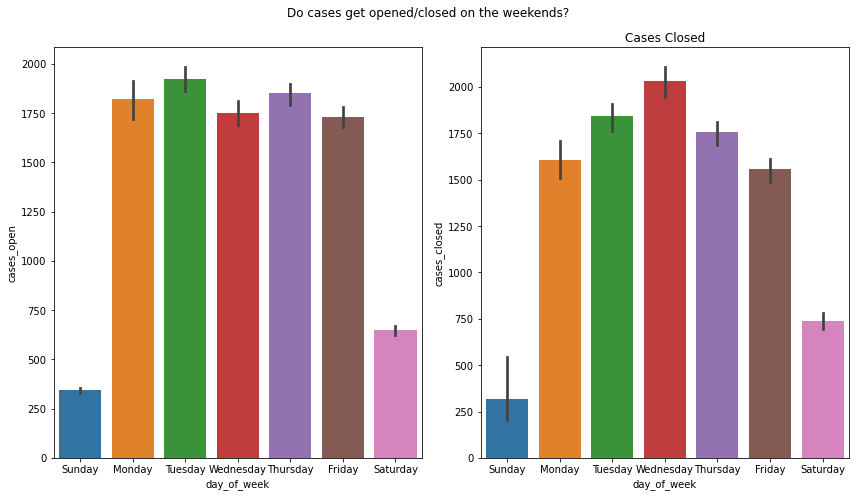

In [26]:
# Cases get open and closed on the weekends but at a lower rate than the week day cases.
f, axes = plt.subplots(1,2, figsize=(12,7))

sns.barplot(data=open_closed, x='day_of_week', y='cases_open', ax=axes[0])
plt.title('Cases Open')
sns.barplot(data=open_closed, x='day_of_week', y='cases_closed', ax=axes[1])
plt.title('Cases Closed')
plt.suptitle("Do cases get opened/closed on the weekends?")
plt.tight_layout()

## 7. On average, how many cases are opened a day for the Customer Service department?

In [27]:
(
    df.filter(df.department == 'Customer Service')
    .select(date_format('case_opened_date', 'yyyy-MM-dd').alias('case_open_date')).show(5)
)

+--------------+
|case_open_date|
+--------------+
|    2018-01-02|
|    2018-01-02|
|    2018-01-02|
|    2018-01-03|
|    2018-01-03|
+--------------+
only showing top 5 rows



In [28]:
(
    df.filter(df.department == 'Customer Service')
    .select(date_format('case_opened_date', 'yyyy-MM-dd').alias('case_open_date'))
    .groupby('case_open_date')
    .count()
    .na.drop()
    .toPandas()
    .sort_values(by='case_open_date')
)

,case_open_date,count
127,2017-01-02,3
200,2017-01-03,6
266,2017-01-04,2
308,2017-01-05,5
102,2017-01-06,3
...,...,...
32,2018-08-02,13
340,2018-08-03,8
33,2018-08-04,2
211,2018-08-06,5


In [29]:
(
    df.filter(df.department == 'Customer Service')
    .select(date_format('case_opened_date', 'yyyy-MM-dd').alias('case_open_date'))
    .groupby('case_open_date')
    .count()
    .na.drop()
    .toPandas()
    .sort_values(by='case_open_date')
    .assign(case_open_date=lambda df: pd.to_datetime(df.case_open_date))
    .set_index('case_open_date')
    ['count'].mean()
)

5.564453125

<AxesSubplot:xlabel='case_open_date'>

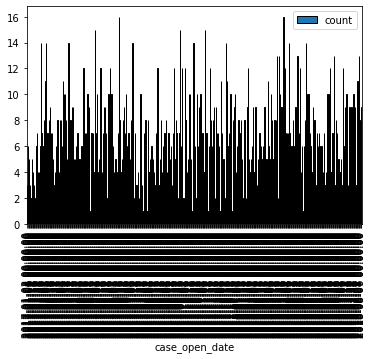

In [35]:
(
    df.filter(df.department == 'Customer Service')
    .select(date_format('case_opened_date', 'yyyy-MM-dd').alias('case_open_date'))
    .groupby('case_open_date')
    .count()
    .na.drop()
    .toPandas()
    .sort_values(by='case_open_date')
    .assign(case_open_date=lambda df: pd.to_datetime(df.case_open_date))
    .set_index('case_open_date')
    .plot.bar(ec='black')
)

## 8. Does the number of service requests for the solid waste department vary by day of the week?

In [30]:
df.show(1,vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



In [31]:
sw_daily_sr = (
    df.filter(df.department == 'Solid Waste')
    .select(date_format('case_opened_date', 'yyyy-MM-dd').alias('case_open_date'))
    .groupby('case_open_date')
    .count()
    .na.drop()
    .toPandas()
    .sort_values('case_open_date')
    .set_index('case_open_date')
    ['count']
)
sw_daily_sr.name = 'cases_open'
sw_daily_sr

case_open_date
2017-01-01     43
2017-01-02    722
2017-01-03    771
2017-01-04    545
2017-01-05    586
             ... 
2018-08-04    175
2018-08-05     90
2018-08-06    775
2018-08-07    714
2018-08-08    191
Name: cases_open, Length: 585, dtype: int64

In [32]:
open_cases = pd.DataFrame(sw_daily_sr)
open_cases

,cases_open
case_open_date,
2017-01-01,43
2017-01-02,722
2017-01-03,771
2017-01-04,545
2017-01-05,586
...,...
2018-08-04,175
2018-08-05,90
2018-08-06,775


In [33]:
#open_cases['day_of_week'] = open_cases.index.day_name()

AttributeError: 'Index' object has no attribute 'day_name'

In [38]:
import matplotlib as mpl

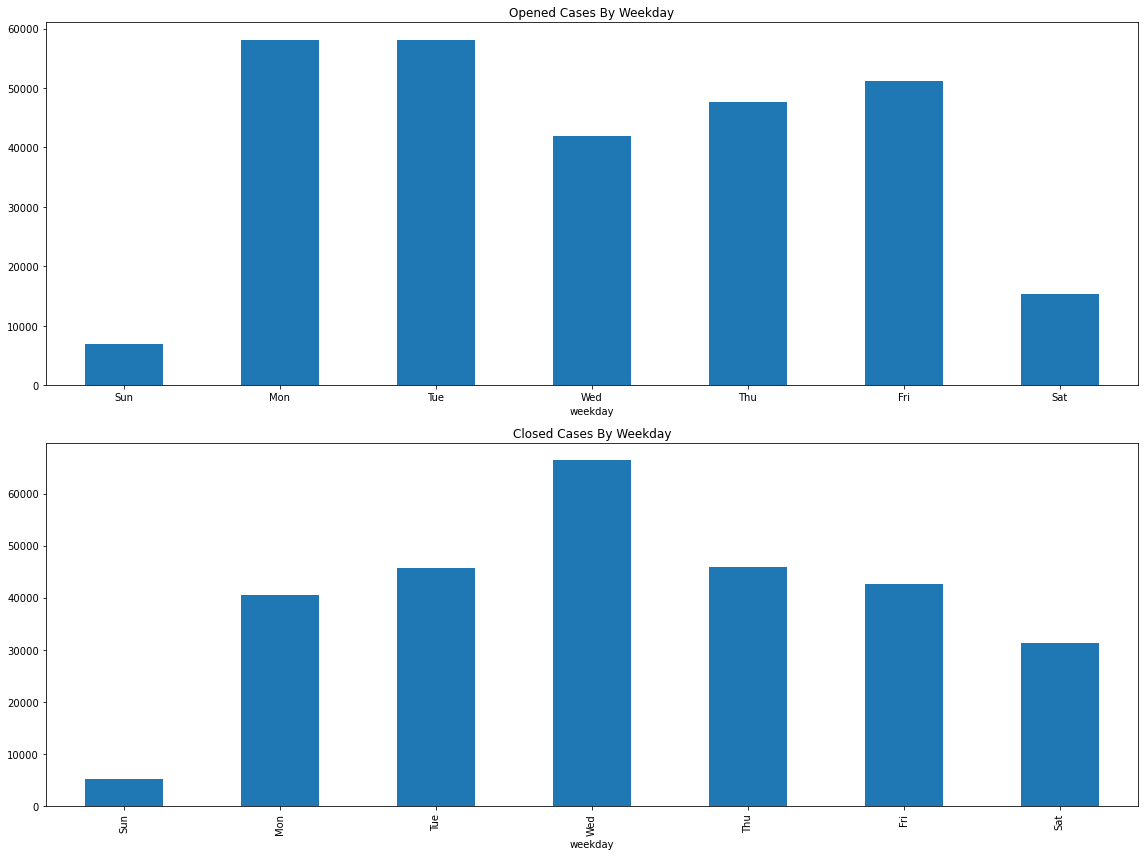

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

(
    df.withColumn("weekday", date_format("case_opened_date", "E"))
    .filter(expr('department == "Solid Waste"'))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index('weekday')['count']
    .sort_index()
    .plot.bar(ax=ax1)
)
ax1.set(
    title='Opened Cases By Weekday'
)
ax1.tick_params(axis='x', labelrotation=0)


(
    df.withColumn("weekday", date_format("case_closed_date", "E"))
    .filter(expr('department == "Solid Waste"'))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index('weekday')['count']
    .sort_index()
    .plot.bar(ax=ax2)
)
ax2.set(
    title='Closed Cases By Weekday'
)
fig.tight_layout()

# Zacks solutions

## 1. How many different cases are there, by department?

In [50]:
plt.style.use("ggplot")
plt.rc("figure", figsize=(13, 7))
plt.rc("font", size=14)

<AxesSubplot:ylabel='department'>

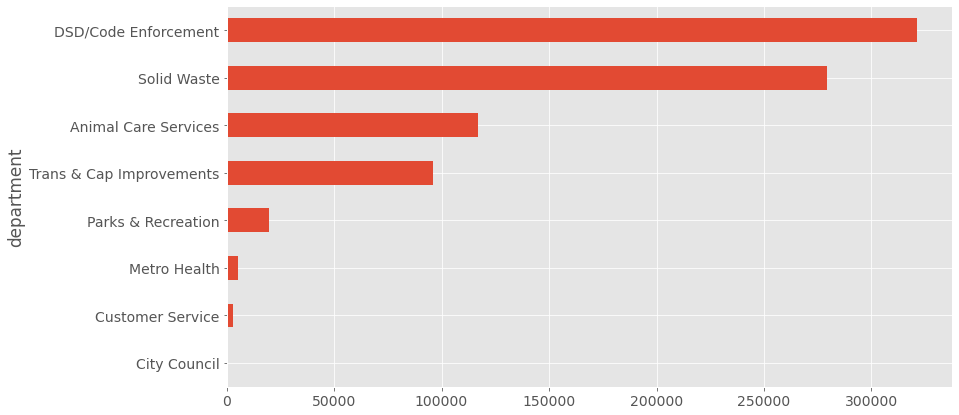

In [51]:
def format_number(x,*args):
    return '{:.0f}k'.format(x/1000)

(
    df.groupby('department')
    .count()
    .toPandas()
    .set_index('department')['count']
    .sort_values()
    .plot.barh()

plt.gca().set(
)